In [1]:
%load_ext autoreload

# GMM with IPOC data

In [2]:
%matplotlib inline
import re
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.features, plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

end = "2016-07-01"

Problems with merging IPOC and other (contininuous) data:
* IPOC triggers can be 10 sec apart
* continuous data has to be resampled to 1 sec
* calculating sliding windows after merging is impossible
* solution found, but too slow on laptop

Load all IPOC measurements for AB1 and join them with continuous measurements for B1 along with sliding window features for all continuous measurements.

In more detail:
1. Query all IPOC data
2. Round timestamps to the second
3. Filter
4. Search all collection names matching regex for other, continuous data
5. Loop over collections
    1. Query the collection
    2. Fill missing values
    3. Filter
    4. Left join IPOC with new collection
    5. Create sliding window features and join with IPOC

In [3]:
# IPOC triggers are all at same time so query can be used
joined = db.query("^.*IPOC.AB1.*", end_datetime=end, filters=True)
# round timestamps to seconds for merging
index = joined.index.round("S")
joined["timestamps"] = index

continuous_pattern = "^MKI\.(A|B).*B1:.*"
collections = [col for col in db.get_all_collections() if re.search(continuous_pattern, col)]

for collection in collections:
    df = db.query(collection, end_datetime=end, resample_to="1s", filters=True)
    df["timestamps"] = df.index
    joined = pd.merge(joined, df, how='left')
    df.drop("timestamps", axis=1, inplace=True)
    
    SWM_T10 = feature_extraction.sliding_window_mean(df, "s", 600)
    SWM_T10["timestamps"] = SWM_T10.index
    joined = pd.merge(joined, SWM_T10, how='left')
    
    SWMD_T10 = feature_extraction.sliding_window_mean_diff(df, "s", 600)
    SWMD_T10["timestamps"] = SWM_T10.index
    joined = pd.merge(joined, SWMD_T10, how='left')
    
    SWS_T10 = feature_extraction.sliding_window_sum(df, "s", 600)
    SWS_T10["timestamps"] = SWS_T10.index
    joined = pd.merge(joined, SWS_T10, how='left')
    print (collection + " loaded with features")

# reset the index and drop it as column
joined.index = joined["timestamps"]
joined.drop("timestamps", axis=1, inplace=True)

Fetching data for pattern ^.*IPOC.AB1.* from 2016-04-16 00:00:00.000000 to 2016-07-01
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:E_KICK
Fetching data for MKI.UA23.IPOC.AB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.AB1:T_START_TH
Fetching data for MKI.UA23.IPOC.AB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.AB1:I_STRENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_DELAY
Fetching data for pattern MKI.A5L2.B1:TEMP_MAGNET_UP from 2016-04-16 00:00:00.000000 to 2016-07-01
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
MKI.A5L2.B1:TEMP_MAGNET_UP loaded with features
Fetching data for pattern MKI.B5L2.B1:PRESSURE from 2016-04-16 00:00:00.000000 to 2016-07-01
Fetching data for MKI.B5L2.B1:PRESSURE
MKI.B5L2.B1:PRESSURE loaded with features
Fetching data for pattern MKI.B5L2.B1:TEMP_TUBE_DOWN from 2016-04-16 00:00:00.000000 to 2016-07-01
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
MKI.B5L2.B1:TEMP_TUBE_DOWN loaded with features
Fetching data for pattern MKI.A5L2.B

In [4]:
display(joined.shape, joined.describe(), joined.head())

(17472, 47)

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                17472.000000              17472.000000   
mean                     5.232219               3342.246717   
std                     11.515457               2735.983749   
min                      2.070600                400.200000   
25%                      2.084400                450.000000   
50%                      2.086900               3028.320000   
75%                      8.076300               6499.440000   
max                    139.369200               7864.200000   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                  17472.000000                  17472.000000   
mean                       1.386411                     53.162932   
std                        1.897371                      7.093008   
min                     -125.379000                    -13.816000   
25%                        1.390400                     52.286000   
50%                        1.394900                     52.287000   
75%                        1.405200                     52.289000   
max                      125.355200                     61.256000   

       MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                  17472.000000                  17472.000000   
mean                       0.654624                      4.772943   
std                        0.062201                      0.500871   
min                       -0.000600                      1.996200   
25%                        0.657500                      4.741075   
50%                        0.658000                      4.882500   
75%                        0.664900                      5.078125   
max                        0.667500                      5.193200   

       MKI.UA23.IPOC.AB1:T_DELAY  MKI.A5L2.B1:TEMP_MAGNET_UP  \
count               17472.000000                17447.000000   
mean                   54.462938                   29.028922   
std                     3.361474                    8.226179   
min                    52.937200                   20.700000   
25%                    52.944100                   21.400000   
50%                    52.946400                   24.700000   
75%                    52.951100                   37.700000   
max                    61.922000                   43.400000   

       MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_600_s  \
count                              17447.000000   
mean                                  29.031326   
std                                    8.229244   
min                                   20.700000   
25%                                   21.400000   
50%                                   24.700000   
75%                                   37.700000   
max                                   43.400000   

       MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_600_s  \
count                                   1.744700e+04   
mean                                   -2.404090e-03   
std                                     3.426966e-02   
min                                    -2.995000e-01   
25%                                    -7.283063e-13   
50%                                     0.000000e+00   
75%                                     7.283063e-13   
max                                     2.880000e-01   

                         ...                      \
count                    ...                       
mean                     ...                       
std                      ...                       
min                      ...                       
25%                      ...                       
50%                      ...                       
75%                      ...                       
max                      ...                       

       MKI.B5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_600_s  \
count                                   1.744700e+04   
mean                                   -3.355305e-03   
std             

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
timestamps                                                                  
2016-04-17 00:50:36                      2.0815                   5951.52   
2016-04-17 00:50:46                      2.0846                   5951.52   
2016-04-17 00:50:56                      2.0842                   5951.52   
2016-04-17 00:51:06                      2.0851                   5951.52   
2016-04-17 00:51:16                      2.0840                   5951.52   

                     MKI.UA23.IPOC.AB1:T_FALLTIME  \
timestamps                                          
2016-04-17 00:50:36                        1.4345   
2016-04-17 00:50:46                        1.4001   
2016-04-17 00:50:56                        1.4008   
2016-04-17 00:51:06                        1.4000   
2016-04-17 00:51:16                        1.3999   

                     MKI.UA23.IPOC.AB1:T_START_TH  \
timestamps                                          
2016-04-17 00:50:36                        52.297   
2016-04-17 00:50:46                        52.287   
2016-04-17 00:50:56                        52.287   
2016-04-17 00:51:06                        52.288   
2016-04-17 00:51:16                        52.287   

                     MKI.UA23.IPOC.AB1:T_RISETIME  \
timestamps                                          
2016-04-17 00:50:36                        0.6593   
2016-04-17 00:50:46                        0.6583   
2016-04-17 00:50:56                        0.6584   
2016-04-17 00:51:06                        0.6583   
2016-04-17 00:51:16                        0.6587   

                     MKI.UA23.IPOC.AB1:I_STRENGTH  MKI.UA23.IPOC.AB1:T_DELAY  \
timestamps                                                                     
2016-04-17 00:50:36                        1.9967                    52.9560   
2016-04-17 00:50:46                        3.5482                    52.9455   
2016-04-17 00:50:56                        3.6494                    52.9456   
2016-04-17 00:51:06                        3.7484                    52.9463   
2016-04-17 00:51:16                        3.8477                    52.9453   

                     MKI.A5L2.B1:TEMP_MAGNET_UP  \
timestamps                                        
2016-04-17 00:50:36                        21.0   
2016-04-17 00:50:46                        21.0   
2016-04-17 00:50:56                        21.0   
2016-04-17 00:51:06                        21.0   
2016-04-17 00:51:16                        21.0   

                     MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_600_s  \
timestamps                                                      
2016-04-17 00:50:36                                      21.0   
2016-04-17 00:50:46                                      21.0   
2016-04-17 00:50:56                                      21.0   
2016-04-17 00:51:06                                      21.0   
2016-04-17 00:51:16                                      21.0   

                     MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_600_s  \
timestamps                                                           
2016-04-17 00:50:36                                            0.0   
2016-04-17 00:50:46                                            0.0   
2016-04-17 00:50:56                                            0.0   
2016-04-17 00:51:06                                            0.0   
2016-04-17 00:51:16                                            0.0   

                                       ...                      \
timestamps                             ...                       
2016-04-17 00:50:36                    ...                       
2016-04-17 00:50:46                    ...                       
2016-04-17 00:50:56                    ...                       
2016-04-17 00:51:06                    ...                       
2016-04-17 00:51:16                    ...                       

                     MKI.B5L2.B1:TEM

In [5]:
joined.tail()

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
timestamps                                                                  
2016-06-30 21:55:36                      9.1400                   6499.56   
2016-06-30 21:55:46                      9.1396                   6499.56   
2016-06-30 21:55:56                      9.1387                   6499.56   
2016-06-30 21:56:06                      9.1397                   6499.56   
2016-06-30 21:56:16                      9.1393                   6499.56   

                     MKI.UA23.IPOC.AB1:T_FALLTIME  \
timestamps                                          
2016-06-30 21:55:36                        1.4278   
2016-06-30 21:55:46                        1.4280   
2016-06-30 21:55:56                        1.4284   
2016-06-30 21:56:06                        1.4275   
2016-06-30 21:56:16                        1.4292   

                     MKI.UA23.IPOC.AB1:T_START_TH  \
timestamps                                          
2016-06-30 21:55:36                        52.289   
2016-06-30 21:55:46                        52.287   
2016-06-30 21:55:56                        52.288   
2016-06-30 21:56:06                        52.288   
2016-06-30 21:56:16                        52.287   

                     MKI.UA23.IPOC.AB1:T_RISETIME  \
timestamps                                          
2016-06-30 21:55:36                        0.6655   
2016-06-30 21:55:46                        0.6655   
2016-06-30 21:55:56                        0.6658   
2016-06-30 21:56:06                        0.6658   
2016-06-30 21:56:16                        0.6656   

                     MKI.UA23.IPOC.AB1:I_STRENGTH  MKI.UA23.IPOC.AB1:T_DELAY  \
timestamps                                                                     
2016-06-30 21:55:36                        5.1089                    52.9543   
2016-06-30 21:55:46                        5.1091                    52.9530   
2016-06-30 21:55:56                        5.1093                    52.9541   
2016-06-30 21:56:06                        5.1092                    52.9537   
2016-06-30 21:56:16                        5.1091                    52.9531   

                     MKI.A5L2.B1:TEMP_MAGNET_UP  \
timestamps                                        
2016-06-30 21:55:36                         NaN   
2016-06-30 21:55:46                         NaN   
2016-06-30 21:55:56                         NaN   
2016-06-30 21:56:06                         NaN   
2016-06-30 21:56:16                         NaN   

                     MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_600_s  \
timestamps                                                      
2016-06-30 21:55:36                                       NaN   
2016-06-30 21:55:46                                       NaN   
2016-06-30 21:55:56                                       NaN   
2016-06-30 21:56:06                                       NaN   
2016-06-30 21:56:16                                       NaN   

                     MKI.A5L2.B1:TEMP_MAGNET_UP:SW_MEAN_DIFF_600_s  \
timestamps                                                           
2016-06-30 21:55:36                                            NaN   
2016-06-30 21:55:46                                            NaN   
2016-06-30 21:55:56                                            NaN   
2016-06-30 21:56:06                                            NaN   
2016-06-30 21:56:16                                            NaN   

                                       ...                      \
timestamps                             ...                       
2016-06-30 21:55:36                    ...                       
2016-06-30 21:55:46                    ...                       
2016-06-30 21:55:56                    ...                       
2016-06-30 21:56:06                    ...                       
2016-06-30 21:56:16                    ...                       

                     MKI.B5L2.B1:TEM

Check distances in consecutive timestamps. Seems to be about 10 seconds usually.

In [6]:
joined["timestamps"] = joined.index
display(joined["timestamps"].diff().describe())
joined.drop("timestamps", inplace=True, axis=1)

count                     17471
mean     0 days 00:06:10.301642
std      0 days 01:56:30.990988
min             0 days 00:00:09
25%             0 days 00:00:10
50%             0 days 00:00:10
75%             0 days 00:00:10
max             6 days 12:52:57
Name: timestamps, dtype: object

Filter out NaN values

In [7]:
joined.isnull().any().any()

True

In [8]:
# MKI.B5L2.B1:PRESSURE had a NaN row
display(joined.shape)
joined = joined.dropna()
display(joined.shape)

(17472, 47)

(17447, 47)

Fitting models for cv_type 'full'
Done with components: 1 2 3 4 
Fitting models for cv_type 'tied'
Done with components: 1 2 3 4 
Fitting models for cv_type 'diag'
Done with components: 1 2 3 4 
Fitting models for cv_type 'spherical'
Done with components: 1 2 3 4 



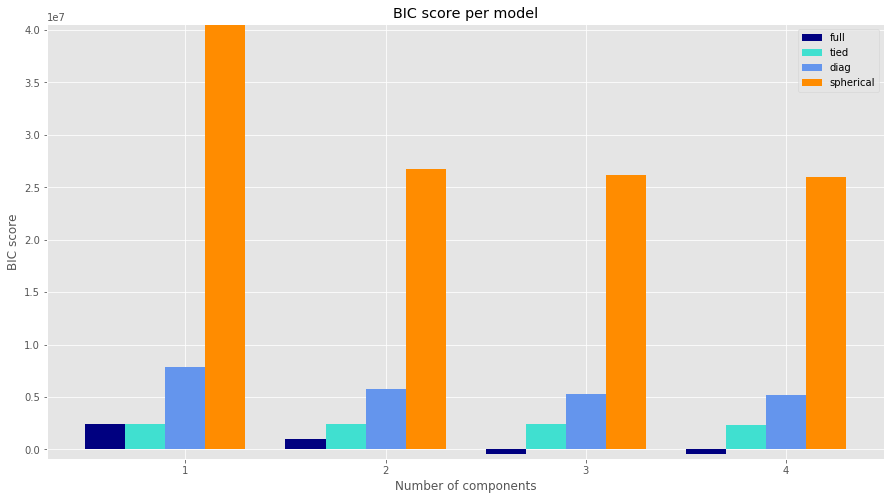

In [9]:
dfs = preprocessing.scale_robust(joined)
bic_scores = GMM.bic_scores(dfs, max_n_components=4)
plot.features.gmm_bic_scores(bic_scores, max_n_components=4, title="BIC score per model")

In [10]:
clf = GMM.GMM(n_components=4, covariance_type='full')
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.anomaly_scores(dfs)
display(pd.Series(log_probs).describe())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))[0]
anomaly_log_probs = log_probs[idx]

count    17447.000000
mean        15.724574
std         32.507541
min       -408.940363
25%         15.002913
50%         31.097571
75%         37.096707
max         41.855999
dtype: float64

'1pct percentile: -63'

In [26]:
p = PCA.PCA(n_components=2)
p_data = p.transform(dfs)

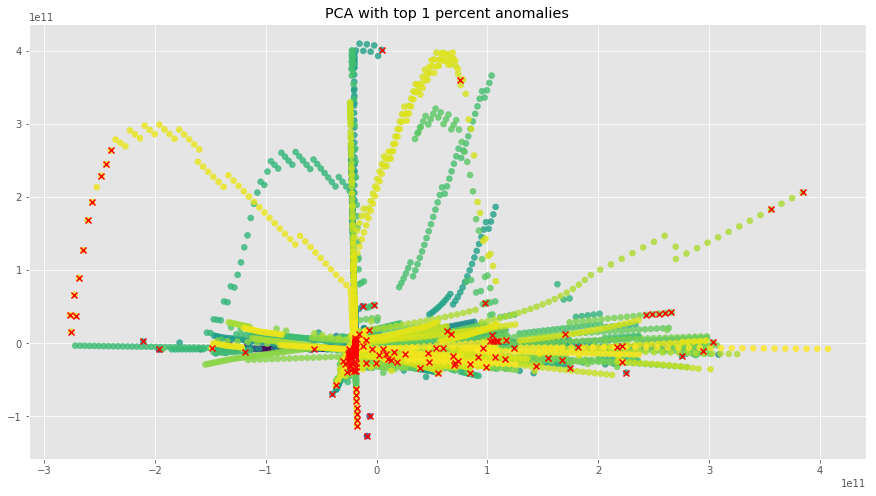

In [31]:
plot.anomalies.pca_anomalies(p_data, idx, "PCA with top 1 percent anomalies", color_coding=True)

Fetch elogbook entries

In [32]:
# OLD METHOD, KEPT IN HERE FOR REFERENCE
df_elogbook = db.query("MKI.ELOGBOOK$", end_datetime=end)
# marker column is to plot it together with other data
df_elogbook['marker'] = 0

Fetching data for pattern MKI.ELOGBOOK$ from 2016-04-16 00:00:00.000000 to 2016-07-01
Fetching data for MKI.ELOGBOOK


In [33]:
elb = db.query_elogbook(end_datetime=end)
elb['marker'] = 0
display(elb.index.equals(df_elogbook.index.sort_values()))
df_elogbook = elb

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


True

I can't query the MKI.ELOGBOOK from startdate, maybe problem with the index?

    => Armin, 2017-12-04: fixed in mongo_client.query_elogbook, see docstring

In [34]:
df_elogbook

C0            EVENTDATE EVENT_ID      PATH  \
2016-04-23 04:00:00   1  23/04/2016 06:00:00  2098246  LHC.MKI8   
2016-04-23 10:15:28   2  23/04/2016 12:15:28  2098379  LHC.MKI8   
2016-04-24 05:19:36   3  24/04/2016 07:19:36  2098811  LHC.MKI8   
2016-04-24 12:03:20   4  24/04/2016 14:03:20  2098949  LHC.MKI8   
2016-04-26 10:00:00   5  26/04/2016 12:00:00  2100547  LHC.MKI8   
2016-04-27 10:00:00   6  27/04/2016 12:00:00  2101272  LHC.MKI8   
2016-04-29 05:35:00   7  29/04/2016 07:35:00  2103179  LHC.MKI8   
2016-05-02 10:00:00   8  02/05/2016 12:00:00  2104505  LHC.MKI2   
2016-05-02 12:59:00   9  02/05/2016 14:59:00  2104506  LHC.MKI8   
2016-05-03 06:30:00  10  03/05/2016 08:30:00  2104890  LHC.MKI8   
2016-05-03 08:50:00  11  03/05/2016 10:50:00  2104988  LHC.MKI8   
2016-05-08 04:00:00  12  08/05/2016 06:00:00  2107261  LHC.MKI8   
2016-05-09 11:00:00  13  09/05/2016 13:00:00  2107892  LHC.MKI8   
2016-05-14 10:00:00  14  14/05/2016 12:00:00  2111007  LHC.MKI2   
2016-05-27 14:30:00  15  27/05/2016 16:30:00  2117307  LHC.MKI8   
2016-05-28 21:10:00  16  28/05/2016 23:10:00  2117978  LHC.MKI8   
2016-05-30 14:00:00  17  30/05/2016 16:00:00  2118913  LHC.MKI8   
2016-05-30 15:56:00  18  30/05/2016 17:56:00  2118930  LHC.MKI8   
2016-05-30 16:05:00  19  30/05/2016 18:05:00  2118933  LHC.MKI8   
2016-06-03 15:00:00  20  03/06/2016 17:00:00  2121575  LHC.MKI8   
2016-06-05 16:00:00  21  05/06/2016 18:00:00  2122733  LHC.MKI8   
2016-06-05 16:00:30  23  05/06/2016 18:00:30  2122746  LHC.MKI8   
2016-06-05 17:18:00  22  05/06/2016 19:18:00  2122744  LHC.MKI8   
2016-06-06 19:39:00  24  06/06/2016 21:39:00  2123579  LHC.MKI8   
2016-06-07 09:39:00  27  07/06/2016 11:39:00  2123726  LHC.MKI8   
2016-06-07 09:39:00  25  07/06/2016 11:39:00  2123724  LHC.MKI2   
2016-06-07 09:40:00  26  07/06/2016 11:40:00  2123725  LHC.MKI8   
2016-06-07 15:53:30  28  07/06/2016 17:53:30  2124340  LHC.MKI2   
2016-06-07 18:56:45  29  07/06/2016 20:56:45  2124341  LHC.MKI8   
2016-06-08 06:00:00  30  08/06/2016 08:00:00  2124342  LHC.MKI2   
2016-06-08 06:44:00  31  08/06/2016 08:44:00  2124349  LHC.MKI8   
2016-06-15 19:12:00  32  15/06/2016 21:12:00  2129438  LHC.MKI2   
2016-06-18 19:59:00  33  18/06/2016 21:59:00  2130953  LHC.MKI8   
2016-06-19 13:14:00  34  19/06/2016 15:14:00  2131267  LHC.MKI2   
2016-06-21 07:20:00  35  21/06/2016 09:20:00  2132379  LHC.MKI8   
2016-06-22 09:38:00  38  22/06/2016 11:38:00  2137763  LHC.MKI2   
2016-06-25 10:00:00  36  25/06/2016 12:00:00  2134999  LHC.MKI8   
2016-06-29 02:00:00  37  29/06/2016 04:00:00  2137656  LHC.MKI2   
2016-06-30 21:23:00  39  30/06/2016 23:23:00  2138252  LHC.MKI2   
2016-06-30 21:35:00  40  30/06/2016 23:35:00  2138259  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_  \
2016-04-23 04:00:00  Piquet contact me for the MKI8 problem with th...   
2016-04-23 10:15:28  At the same moment as the LBDS XPOC fault, the...   
2016-04-24 05:19:36  CCC LHC calls for MKI8 faulty. Same problem as...   
2016-04-24 12:03:20  CCC calls, again SVM fault for KTC6 rack. I tr...   
2016-04-26 10:00:00  High vacuum in MKI8d-Q5 interconnect during sc...   
2016-04-27 10:00:00  SIS vacuum threshold for interconnect MKI8D-Q5...   
2016-04-29 05:35:00  MKI8 in fault - water flow missing..... To be ...   
2016-05-02 10:00:00  Stopped the MKI2 today around 12.00 am to 'bur...   
2016-05-02 12:59:00  Stopped the MKI8 today around 12.00 am to 'bur...   
2016-05-03 06:30:00  Increased SIS vacuum integral threshold from 1...   
2016-05-03 08:50:00  Went with PVT to MKI8 to swap power supply typ...   
2016-05-08 04:00:00  MKI8 monitoring supply on KTC6 appeared again ...   
2016-05-09 11:00:00  Intervention on MKI8 Beam 2 for the SVM (surve...   
2016-05-14 10:00:00  Called at midnight for a fault on the MKI2 Bea...   
2016-05-27 14:30:00  Fault on S23 KTC6 (Rack MYGP03). Reset OK.\nBu...   
2016-05-28 21:10:00  Called at 21:58 for a fault on MKI8.\nFault on...   
2016-05-30 14:0

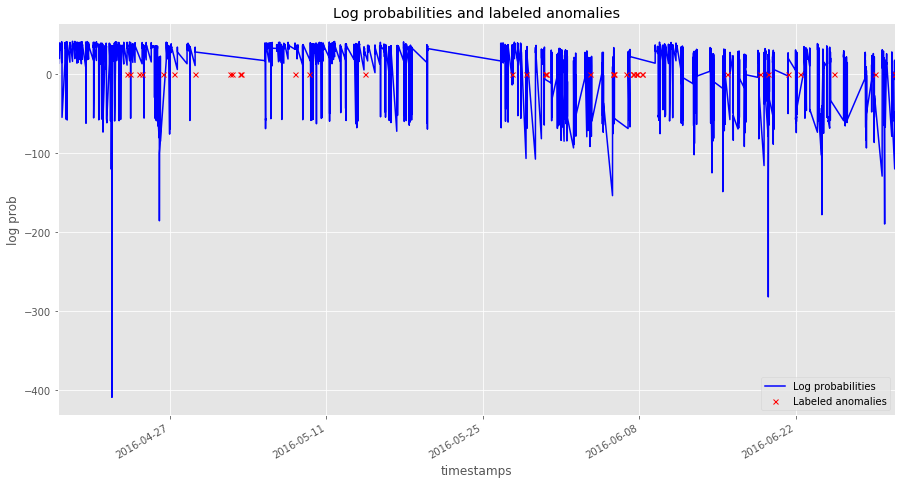

In [35]:
df_log_probs = pd.DataFrame(data=log_probs, index=dfs.index)
plot.anomalies.gmm_logprobs_anomalies(df_log_probs, df_elogbook)

In [36]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

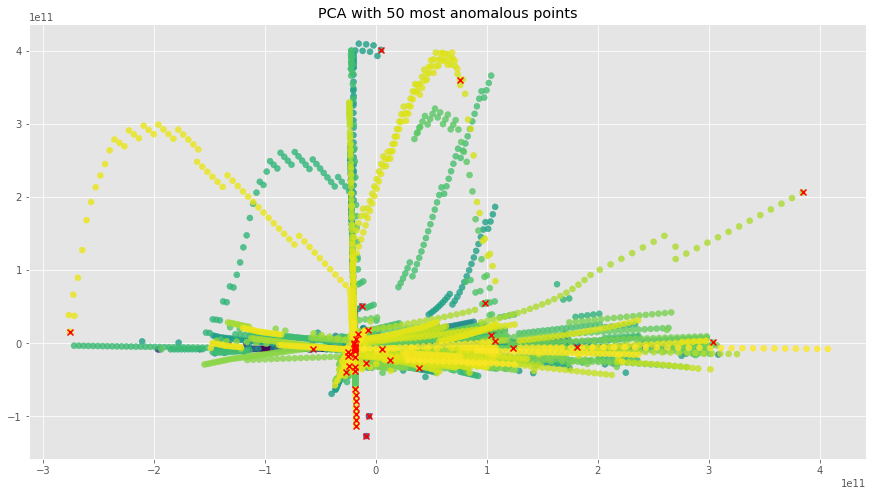

In [38]:
plot.anomalies.pca_anomalies(p_data, top50, "PCA with 50 most anomalous points", color_coding=True)

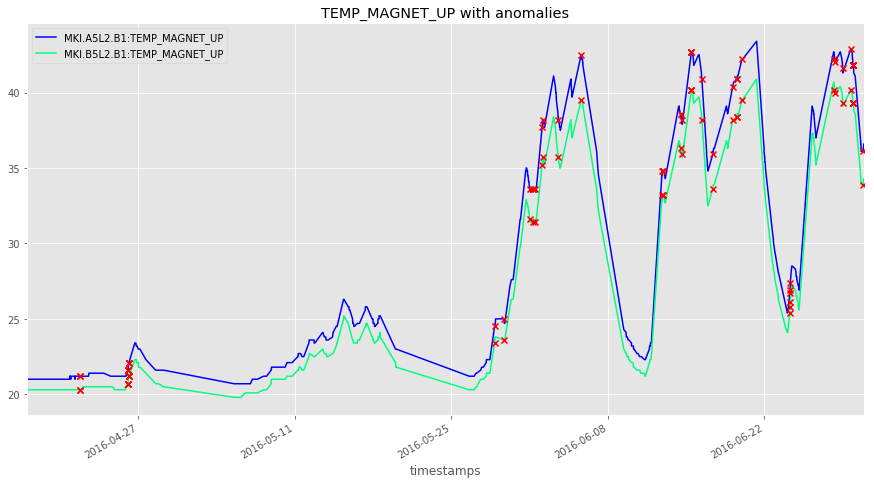

In [22]:
plot.anomalies.timeseries_anomalies(joined, "TEMP_MAGNET_UP", top50)

! Interpolation happens in the figure ! Not every point in time is in the dataframe, only IPOC trigger times